# Extracción de caracteristicas proyecto:
# Clasificación de supernovas de ALeRCE - ZTF
### Por Joaquin Zepeda y Benjamin Irarrazabal - Tutor: Pablo Montero


In [4]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

Obtaining turbofats from git+https://****@github.com/alercebroker/turbo-fats#egg=turbofats
  Cloning https://****@github.com/alercebroker/turbo-fats to ./src/turbofats
  Running command git clone -q 'https://****@github.com/alercebroker/turbo-fats' /content/src/turbofats
  Running setup.py develop for turbofats
Obtaining mhps from git+https://****@github.com/alercebroker/mhps#egg=mhps
  Cloning https://****@github.com/alercebroker/mhps to ./src/mhps
  Running command git clone -q 'https://****@github.com/alercebroker/mhps' /content/src/mhps
  Running setup.py develop for mhps
Obtaining P4J from git+https://****@github.com/alercebroker/P4J#egg=P4J
  Cloning https://****@github.com/alercebroker/P4J to ./src/p4j
  Running command git clone -q 'https://****@github.com/alercebroker/P4J' /content/src/p4j
  Running setup.py develop for P4J
Obtaining lc_classifier from git+https://****@github.com/alercebroker/lc_classifier#egg=lc_classifier
  Cloning https://****@github.com/alercebroker/lc_cla

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
inicio_ejecucion = time.time()
# Se imprime la version de Tensorflow
print('Tensorflow version', tf.__version__)

Tensorflow version 2.6.0


In [2]:
from lc_classifier.features import MHPSExtractor, PeriodExtractor, GPDRWExtractor
from lc_classifier.features import FoldedKimExtractor
from lc_classifier.features import HarmonicsExtractor, IQRExtractor, SupernovaeDetectionFeatureExtractor
from lc_classifier.features import PowerRateExtractor
from lc_classifier.features import TurboFatsFeatureExtractor

from lc_classifier.features import FeatureExtractorComposer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
'''
2.- Los extractores de características recomendados son:

SupernovaeDetectionFeatureExtractor(band_names),
SNParametricModelExtractor(band_names),
IQRExtractor(band_names),
MHPSExtractor(band_names),
TurboFatsFeatureExtractor(band_names),
GPDRWExtractor(band_names),
PowerRateExtractor(band_names),
PeriodExtractor(band_names),
HarmonicsExtractor(band_names),

FeatureExtractorComposer(
    [
        MHPSExtractor(bands),
        PeriodExtractor(bands),
        GPDRWExtractor(bands),
        FoldedKimExtractor(bands),
        HarmonicsExtractor(bands),
        IQRExtractor(bands),
        PowerRateExtractor(bands),
        TurboFatsFeatureExtractor(bands)
    ]
)
'''
bands = [1,2]
feature_extractor = FeatureExtractorComposer(
    [
        SupernovaeDetectionFeatureExtractor(bands),
        MHPSExtractor(bands),
        GPDRWExtractor(bands),
        FoldedKimExtractor(bands),
        HarmonicsExtractor(bands),
        PowerRateExtractor(bands),
        TurboFatsFeatureExtractor(bands)
    ]
)


In [4]:
url_det='https://raw.githubusercontent.com/joaquinzepeda/Datos/main/datos%20supernovas/detections_SNe_v7.0.1.csv'
url_dfcross='https://raw.githubusercontent.com/joaquinzepeda/Datos/main/datos%20supernovas/dfcrossmatches_prioritized_v7.0.1.csv'
detections = pd.read_csv(url_det, index_col=None)
dfcrossmatches = pd.read_csv(url_dfcross, index_col=None)

In [5]:
from scipy import stats

Conjunto = pd.merge(detections, dfcrossmatches, left_on='objectId', right_on='oid')
slice_cjto = Conjunto[['oid','fid', 'isdiffpos', 'sigmapsf','sigmapsf_corr', 'field',
       'fwhm', 'dec_x', 'magpsf', 'magpsf_corr', 'rcid', 'ra_x', 'sky', 'rb', 'ssmagnr',
       'distpsnr3', 'sgscore2', 'maggaiabright', 'distpsnr2', 'distpsnr1',
       'maggaia', 'exptime', 'drb', 'sgscore3', 'neargaia', 'sgscore1', 'mjd', 'has_stamp', 'ra_y', 'dec_y', 'classALeRCE']]
clean_data = slice_cjto[((np.abs(stats.zscore(slice_cjto['magpsf']))<3)&(slice_cjto['sigmapsf']<1))]

n = len(clean_data)
copy_cleandata = clean_data.copy()


In [6]:
j=0
indice_magpsf_corr = 0
indice_sigmapsf_corr = 0
for columna in copy_cleandata.columns:
    if columna=='magpsf_corr':
        print(columna)
        indice_magpsf_corr = j
    if columna=='sigmapsf_corr':
        print(columna)
        indice_sigmapsf_corr = j
    j+=1
indice_magpsf_corr,indice_sigmapsf_corr 

sigmapsf_corr
magpsf_corr


(9, 4)

In [7]:
for i in range(0,n):
  if pd.isna(clean_data.iloc[i,indice_magpsf_corr]) == True:
    copy_cleandata.iloc[i,indice_magpsf_corr] = copy_cleandata.iloc[i,indice_magpsf_corr-1]
  else:
    pass
for i in range(0,n):
  if pd.isna(clean_data.iloc[i,indice_sigmapsf_corr ]) == True:
    copy_cleandata.iloc[i,indice_sigmapsf_corr ] = copy_cleandata.iloc[i,indice_sigmapsf_corr-1]
  else:
    pass


In [8]:
copy_cleandata.head()

,oid,fid,isdiffpos,sigmapsf,sigmapsf_corr,field,fwhm,dec_x,magpsf,magpsf_corr,rcid,ra_x,sky,rb,ssmagnr,distpsnr3,sgscore2,maggaiabright,distpsnr2,distpsnr1,maggaia,exptime,drb,sgscore3,neargaia,sgscore1,mjd,has_stamp,ra_y,dec_y,classALeRCE
2,ZTF18aahvndq,1,1.0,0.032161,0.032161,626,1.98,27.008647,16.072975,16.072975,34,198.722653,-1.455619,0.907143,-999.0,21.647310,0.001667,-999.0,21.608295,2.075565,17.138538,30.0,0.999939,0.5,78.111310,0.175976,59004.192674,True,198.722653,27.008637,SNIa
3,ZTF18aahvndq,1,1.0,0.049931,0.049931,626,2.75,27.008624,17.708502,17.708502,34,198.722660,0.167642,0.947143,-999.0,21.641445,0.001667,-999.0,21.600946,1.995552,17.138538,30.0,0.999956,0.5,78.077545,0.175976,59021.227604,True,198.722653,27.008637,SNIa
6,ZTF18aahvndq,1,1.0,0.044748,0.044748,626,3.49,27.008622,16.626165,16.626165,34,198.722665,0.045623,0.818571,-999.0,21.655378,0.001667,-999.0,21.614609,1.985925,17.138538,30.0,0.999150,0.5,78.058230,0.175976,59009.258669,True,198.722653,27.008637,SNIa
8,ZTF18aahvndq,1,1.0,0.078094,0.078094,626,2.24,27.008641,18.192377,18.192377,34,198.722675,-0.013109,0.967143,-999.0,21.707882,0.001667,-999.0,21.668118,2.056663,17.138538,30.0,0.999988,0.5,78.038506,0.175976,59036.198090,True,198.722653,27.008637,SNIa
9,ZTF18aahvndq,1,1.0,0.083104,0.083104,626,2.28,27.008652,18.481302,18.481302,34,198.722666,0.026185,0.960000,-999.0,21.691038,0.001667,-999.0,21.652124,2.095366,17.138538,30.0,0.999997,0.5,78.075700,0.175976,59045.238090,False,198.722653,27.008637,SNIa


In [9]:
# Ahora, tomaremos un ejemplo de cada supernova y graficaremos su curva de luz.
datos_final = copy_cleandata #Las muestras con los NaN reemplazados y sin outliers

In [10]:
#copy_cleandata.columns

In [11]:
try:
    datos_final = datos_final.set_index('oid')
except:
    print('oid is already the index')
datos_final.head()

,fid,isdiffpos,sigmapsf,sigmapsf_corr,field,fwhm,dec_x,magpsf,magpsf_corr,rcid,ra_x,sky,rb,ssmagnr,distpsnr3,sgscore2,maggaiabright,distpsnr2,distpsnr1,maggaia,exptime,drb,sgscore3,neargaia,sgscore1,mjd,has_stamp,ra_y,dec_y,classALeRCE
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF18aahvndq,1,1.0,0.032161,0.032161,626,1.98,27.008647,16.072975,16.072975,34,198.722653,-1.455619,0.907143,-999.0,21.647310,0.001667,-999.0,21.608295,2.075565,17.138538,30.0,0.999939,0.5,78.111310,0.175976,59004.192674,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.049931,0.049931,626,2.75,27.008624,17.708502,17.708502,34,198.722660,0.167642,0.947143,-999.0,21.641445,0.001667,-999.0,21.600946,1.995552,17.138538,30.0,0.999956,0.5,78.077545,0.175976,59021.227604,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.044748,0.044748,626,3.49,27.008622,16.626165,16.626165,34,198.722665,0.045623,0.818571,-999.0,21.655378,0.001667,-999.0,21.614609,1.985925,17.138538,30.0,0.999150,0.5,78.058230,0.175976,59009.258669,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.078094,0.078094,626,2.24,27.008641,18.192377,18.192377,34,198.722675,-0.013109,0.967143,-999.0,21.707882,0.001667,-999.0,21.668118,2.056663,17.138538,30.0,0.999988,0.5,78.038506,0.175976,59036.198090,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.083104,0.083104,626,2.28,27.008652,18.481302,18.481302,34,198.722666,0.026185,0.960000,-999.0,21.691038,0.001667,-999.0,21.652124,2.095366,17.138538,30.0,0.999997,0.5,78.075700,0.175976,59045.238090,False,198.722653,27.008637,SNIa


In [12]:
import warnings
import time
warnings.filterwarnings("ignore")
inicio = time.time()

detections_df= datos_final.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band','sigmapsf':'error'})
features = feature_extractor.compute_features(detections_df)
fin = time.time()
features

ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19aawgopm
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19acihlft
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aamuqwn
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aavpnlv
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aaynrrh
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19aawgopm
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19acihlft
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aamuqwn
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aavpnlv
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aaynrrh
'NoneType' obj

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_non_zero_1,MHPS_PN_flag_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,Harmonics_mag_4_1,...,PairSlopeTrend_1,PercentAmplitude_1,Q31_1,Rcs_1,Skew_1,SmallKurtosis_1,Std_1,StetsonK_1,Pvar_1,ExcessVar_1,SF_ML_amplitude_1,SF_ML_gamma_1,IAR_phi_1,LinearTrend_1,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Eta_e_2,Gskew_2,MaxSlope_2,Mean_2,Meanvariance_2,MedianAbsDev_2,MedianBRP_2,PairSlopeTrend_2,PercentAmplitude_2,Q31_2,Rcs_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0,24.510580,3.971278,0.162023,18.0,0.0,26.178661,1.065202,0.040690,36.0,0.0,0.623412,11.018541,2.974256e-01,12.709005,0.441628,0.342535,0.361719,0.345065,5.176898e+01,2.247800e+01,16.378288,8.031787,...,-0.166667,0.072278,0.946885,0.441628,-0.195436,-0.887309,0.738558,0.889958,1.000000,0.001442,0.282795,-0.329287,0.903700,0.019445,0.923865,0.999412,3.0,0.222222,0.0,NaN,0.511683,NaN,18.540755,0.025176,0.346074,0.388889,-0.500000,0.063359,0.657760,0.361719,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989
ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0,0.216739,0.046887,0.216330,9.0,0.0,NaN,NaN,NaN,NaN,NaN,0.062597,5.697961,5.886294e-07,0.983179,0.429391,1.045772,NaN,NaN,5.805312e+00,2.222749e+00,2.623629,1.479667,...,0.200000,0.026404,0.487402,0.429391,-0.372776,0.352459,0.282949,0.869288,1.000000,0.000179,5.628182,0.668270,0.841811,0.026267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0,0.752135,0.016245,0.021599,14.0,0.0,8.221117,0.073785,0.008975,20.0,0.0,0.012080,1.541608,7.029221e-02,15.265901,0.366780,1.010175,0.364474,0.463809,3.731002e+00,1.030580e+00,4.626807,2.398018,...,-0.233333,0.016526,0.268495,0.429446,0.540841,-0.226346,0.167338,0.888397,0.593904,-0.000013,15.000000,3.000000,0.799329,0.011157,0.393497,0.999341,2.0,0.100000,0.0,NaN,0.379781,NaN,19.284748,0.011028,0.105004,0.200000,-0.366667,0.030335,0.257782,0.381896,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806
ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0,337.794556,34.621597,0.102493,16.0,0.0,342.520355,12.741676,0.037200,30.0,0.0,2.073645,117.090145,9.575899e-01,191.232153,0.434424,0.953035,0.270602,0.644786,7.272322e+00,2.503748e+00,2.237135,0.544766,...,0.033333,0.101545,1.525995,0.434424,-0.190186,-0.920358,1.116009,0.908434,1.000000,0.003541,15.000000,1.110163,0.986739,0.053669,1.085049,0.990112,6.0,0.200000,0.0,NaN,-0.184004,NaN,17.551116,0.037748,0.418592,0.466667,-0.100000,0.066553,0.901432,0.403816,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800
ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0,0.751511,0.199288,0.265183,24.0,0.0,2.862207,0.223176,0.077974,30.0,0.0,0.244002,10.663540,6.321870e-02,12.420504,0.352905,0.604876,0.412181,0.379704

In [13]:
tiempo_de_extraccion = (fin-inicio)/60
print(f'La extracción de caracteristicas se demoro {"{:.2f}".format(tiempo_de_extraccion)} minutos')

La extracción de caracteristicas se demoro 21.37 minutos


In [14]:
features.reset_index()

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_non_zero_1,MHPS_PN_flag_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,...,PairSlopeTrend_1,PercentAmplitude_1,Q31_1,Rcs_1,Skew_1,SmallKurtosis_1,Std_1,StetsonK_1,Pvar_1,ExcessVar_1,SF_ML_amplitude_1,SF_ML_gamma_1,IAR_phi_1,LinearTrend_1,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Eta_e_2,Gskew_2,MaxSlope_2,Mean_2,Meanvariance_2,MedianAbsDev_2,MedianBRP_2,PairSlopeTrend_2,PercentAmplitude_2,Q31_2,Rcs_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
0,ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,48.854525,19.799040,18.540755,17.951310,36.0,0.0,36.0,1.0,24.510580,3.971278,0.162023,18.0,0.0,26.178661,1.065202,0.040690,36.0,0.0,0.623412,11.018541,2.974256e-01,12.709005,0.441628,0.342535,0.361719,0.345065,5.176898e+01,2.247800e+01,16.378288,...,-0.166667,0.072278,0.946885,0.441628,-0.195436,-0.887309,0.738558,0.889958,1.000000,0.001442,0.282795,-0.329287,0.903700,0.019445,0.923865,0.999412,3.0,0.222222,0.0,NaN,0.511683,NaN,18.540755,0.025176,0.346074,0.388889,-0.500000,0.063359,0.657760,0.361719,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989
1,ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,10.058981,18.633383,18.729251,18.633383,2.0,0.0,2.0,1.0,0.216739,0.046887,0.216330,9.0,0.0,NaN,NaN,NaN,NaN,NaN,0.062597,5.697961,5.886294e-07,0.983179,0.429391,1.045772,NaN,NaN,5.805312e+00,2.222749e+00,2.623629,...,0.200000,0.026404,0.487402,0.429391,-0.372776,0.352459,0.282949,0.869288,1.000000,0.000179,5.628182,0.668270,0.841811,0.026267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,27.982234,19.321800,19.284748,19.027960,20.0,0.0,20.0,1.0,0.752135,0.016245,0.021599,14.0,0.0,8.221117,0.073785,0.008975,20.0,0.0,0.012080,1.541608,7.029221e-02,15.265901,0.366780,1.010175,0.364474,0.463809,3.731002e+00,1.030580e+00,4.626807,...,-0.233333,0.016526,0.268495,0.429446,0.540841,-0.226346,0.167338,0.888397,0.593904,-0.000013,15.000000,3.000000,0.799329,0.011157,0.393497,0.999341,2.0,0.100000,0.0,NaN,0.379781,NaN,19.284748,0.011028,0.105004,0.200000,-0.366667,0.030335,0.257782,0.381896,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806
3,ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,76.909931,16.508772,17.551116,16.508772,30.0,0.0,30.0,1.0,337.794556,34.621597,0.102493,16.0,0.0,342.520355,12.741676,0.037200,30.0,0.0,2.073645,117.090145,9.575899e-01,191.232153,0.434424,0.953035,0.270602,0.644786,7.272322e+00,2.503748e+00,2.237135,...,0.033333,0.101545,1.525995,0.434424,-0.190186,-0.920358,1.116009,0.908434,1.000000,0.003541,15.000000,1.110163,0.986739,0.053669,1.085049,0.990112,6.0,0.200000,0.0,NaN,-0.184004,NaN,17.551116,0.037748,0.418592,0.466667,-0.100000,0.066553,0.901432,0.403816,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800
4,ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,36.979248,19.220867,18.851365,18.423500,30.0,0.0,30.0,1.0,0.751511,0.199288,0.265183,24.0,0.0,2.862207,0.223176,0.077974,30.0,0.0,0.244002,10.663540,6.321870e-02,12.420504,0.352905,0.604876,0.412181,0.379704,4.480328e+00,5.014134e+00,4.117690,...,-0.366667,0.040328,0.784556,0.447261,-0.146487,-1.049990,0.443670,0.813092,1.000000,0

In [15]:
#-------Por revisar------------
'''
oid ZTF19aawgopm
oid ZTF19acihlft
oid ZTF20aamuqwn
oid ZTF20aavpnlv
oid ZTF20aaynrrh
oid ZTF19aawgopm
oid ZTF19acihlft
'''
datos_final[datos_final.index=='ZTF19acihlft']

,fid,isdiffpos,sigmapsf,sigmapsf_corr,field,fwhm,dec_x,magpsf,magpsf_corr,rcid,ra_x,sky,rb,ssmagnr,distpsnr3,sgscore2,maggaiabright,distpsnr2,distpsnr1,maggaia,exptime,drb,sgscore3,neargaia,sgscore1,mjd,has_stamp,ra_y,dec_y,classALeRCE
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF19acihlft,1,1.0,0.162876,100.000000,390,2.71,-10.183966,19.108986,17.352884,16,325.972663,-0.019645,0.957143,-999.0,5.229413,0.5,13.956782,3.582393,1.179483,18.206055,30.0,0.999879,0.5,55.420258,0.164857,58782.211250,True,325.972675,-10.183955,SNIa
ZTF19acihlft,1,1.0,0.104800,0.030519,390,5.07,-10.183993,17.668047,16.877300,16,325.972673,0.725036,0.735714,-999.0,5.283050,0.5,13.956782,3.580775,1.277156,18.206055,30.0,0.999487,0.5,55.518864,0.164857,58830.108183,False,325.972675,-10.183955,SNIa
ZTF19acihlft,1,1.0,0.029123,0.015243,390,2.81,-10.183949,16.201582,15.935588,16,325.972703,-0.002780,0.798571,-999.0,5.093779,0.5,13.956782,3.737263,1.142273,18.206055,30.0,0.999991,0.5,55.441986,0.164857,58789.182153,True,325.972675,-10.183955,SNIa
ZTF19acihlft,2,1.0,0.153177,100.000000,390,1.65,-10.183935,19.155579,16.822386,16,325.972659,-0.157880,0.934286,-999.0,5.148302,0.5,13.956782,3.614844,1.065247,18.206055,30.0,0.999755,0.5,55.316890,0.164857,58782.181609,True,325.972675,-10.183955,SNIa
ZTF19acihlft,2,1.0,0.038713,100.000000,390,2.47,-10.183946,16.194202,15.757371,16,325.972687,0.553173,0.895714,-999.0,5.119776,0.5,13.956782,3.690016,1.121783,18.206055,30.0,0.999999,0.5,55.405365,0.164857,58812.089965,True,325.972675,-10.183955,SNIa
ZTF19acihlft,2,1.0,0.030518,100.000000,390,2.51,-10.183954,16.297045,15.825058,16,325.972701,0.019230,0.911429,-999.0,5.112884,0.5,13.956782,3.723165,1.157916,18.206055,30.0,0.999999,0.5,55.453045,0.164857,58789.211586,True,325.972675,-10.183955,SNIa
ZTF19acihlft,2,1.0,0.059134,100.000000,390,2.51,-10.183957,17.579530,16.471671,16,325.972689,0.394390,0.944286,-999.0,5.148794,0.5,13.956782,3.678403,1.161028,18.206055,30.0,0.999996,0.5,55.440636,0.164857,58785.233032,True,325.972675,-10.183955,SNIa


In [16]:
cells = features[features.index=='ZTF18aaaqexr'].values
indices=[]
i=0
for cell in cells[0]:
    if str(cell)=='nan':
        indices.append(i)
    i+=1    
print(indices)
# Como se puede observar, hay algunas caracteristicas que contienen nan, estas hay que revisarlas
# por separado pues se deben a errores
nan = features.iloc[:, indices]
nan.head()

[23, 24, 25, 26, 27, 34, 35, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121]


,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,MHPS_non_zero_2,MHPS_PN_flag_2,Psi_CS_2,Psi_eta_2,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Eta_e_2,Gskew_2,MaxSlope_2,Mean_2,Meanvariance_2,MedianAbsDev_2,MedianBRP_2,PairSlopeTrend_2,PercentAmplitude_2,Q31_2,Rcs_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,26.178661,1.065202,0.040690,36.0,0.0,0.361719,0.345065,0.923865,0.999412,3.0,0.222222,0.0,NaN,0.511683,NaN,18.540755,0.025176,0.346074,0.388889,-0.500000,0.063359,0.657760,0.361719,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989
ZTF18aaaqexr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aacdbzx,8.221117,0.073785,0.008975,20.0,0.0,0.364474,0.463809,0.393497,0.999341,2.0,0.100000,0.0,NaN,0.379781,NaN,19.284748,0.011028,0.105004,0.200000,-0.366667,0.030335,0.257782,0.381896,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806
ZTF18aadmssd,342.520355,12.741676,0.037200,30.0,0.0,0.270602,0.644786,1.085049,0.990112,6.0,0.200000,0.0,NaN,-0.184004,NaN,17.551116,0.037748,0.418592,0.466667,-0.100000,0.066553,0.901432,0.403816,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800
ZTF18aadzfso,2.862207,0.223176,0.077974,30.0,0.0,0.412181,0.379704,0.398684,0.995344,5.0,0.466667,0.0,NaN,-0.186729,NaN,18.851365,0.012635,0.144352,0.200000,-0.433333,0.026013,0.338915,0.430145,-0.444814,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069


In [17]:
banned_features = [
   'W1', 'W2', 'W3', 'W4',
   'iqr_1',
   'iqr_2',
   'delta_mjd_fid_1',
   'delta_mjd_fid_2',
   'last_mjd_before_fid_1',
   'last_mjd_before_fid_2',
   'g-r_ml',
   'MHAOV_Period_1', 'MHAOV_Period_2'
]
banned_features1 = ['mean_mag_1',
   'mean_mag_2',
   'min_mag_1',
   'min_mag_2',
   'Mean_1',
   'Mean_2',
   'n_det_1',
   'n_det_2',
   'n_pos_1',
   'n_pos_2',
   'n_neg_1',
   'n_neg_2',
   'first_mag_1',
   'first_mag_2',
   'MHPS_non_zero_1',
   'MHPS_non_zero_2',
   'MHPS_PN_flag_1',
   'MHPS_PN_flag_2']


features_clean = features.drop(['Eta_e_1','MaxSlope_1','Eta_e_2','MaxSlope_2'], axis=1)
features_clean = features_clean.drop(banned_features1, axis=1)
features_clean

,delta_mag_fid_1,delta_mjd_fid_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,positive_fraction_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,Harmonics_mag_4_1,Harmonics_mag_5_1,Harmonics_mag_6_1,Harmonics_mag_7_1,Harmonics_phase_2_1,Harmonics_phase_3_1,Harmonics_phase_4_1,Harmonics_phase_5_1,Harmonics_phase_6_1,Harmonics_phase_7_1,Harmonics_mse_1,Harmonics_mag_1_2,Harmonics_mag_2_2,Harmonics_mag_3_2,Harmonics_mag_4_2,Harmonics_mag_5_2,Harmonics_mag_6_2,...,Meanvariance_1,MedianAbsDev_1,MedianBRP_1,PairSlopeTrend_1,PercentAmplitude_1,Q31_1,Rcs_1,Skew_1,SmallKurtosis_1,Std_1,StetsonK_1,Pvar_1,ExcessVar_1,SF_ML_amplitude_1,SF_ML_gamma_1,IAR_phi_1,LinearTrend_1,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Gskew_2,Meanvariance_2,MedianAbsDev_2,MedianBRP_2,PairSlopeTrend_2,PercentAmplitude_2,Q31_2,Rcs_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,1.0,1.847730,48.854525,1.0,24.510580,3.971278,0.162023,26.178661,1.065202,0.040690,0.623412,11.018541,2.974256e-01,12.709005,0.441628,0.342535,0.361719,0.345065,5.176898e+01,2.247800e+01,16.378288,8.031787,35.167310,45.593497,65.823023,2.799746,3.812070,4.416340,3.855748,0.801975,3.920080,4.069061e-24,0.740893,0.297765,0.634379,0.304776,0.411475,0.169551,...,0.038693,0.559760,0.222222,-0.166667,0.072278,0.946885,0.441628,-0.195436,-0.887309,0.738558,0.889958,1.000000,0.001442,0.282795,-0.329287,0.903700,0.019445,0.923865,0.999412,3.0,0.222222,0.0,0.511683,0.025176,0.346074,0.388889,-0.500000,0.063359,0.657760,0.361719,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989
ZTF18aaaqexr,0.896138,18.870671,1.0,0.191736,10.058981,1.0,0.216739,0.046887,0.216330,NaN,NaN,NaN,0.062597,5.697961,5.886294e-07,0.983179,0.429391,1.045772,NaN,NaN,5.805312e+00,2.222749e+00,2.623629,1.479667,2.946373,2.618439,1.582411,2.209948,3.903036,1.966469,0.564790,3.835875,0.632893,1.865218e-28,2.142465,2.539400,4.531156,1.723409,2.910105,4.460812,...,0.014909,0.220421,0.222222,0.200000,0.026404,0.487402,0.429391,-0.372776,0.352459,0.282949,0.869288,1.000000,0.000179,5.628182,0.668270,0.841811,0.026267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aacdbzx,0.495977,19.991725,1.0,0.786995,27.982234,1.0,0.752135,0.016245,0.021599,8.221117,0.073785,0.008975,0.012080,1.541608,7.029221e-02,15.265901,0.366780,1.010175,0.364474,0.463809,3.731002e+00,1.030580e+00,4.626807,2.398018,2.417238,1.966842,6.632274,5.789298,4.023447,2.294776,3.697512,4.121476,5.312111,1.992437e-28,621.990994,304.401458,1578.914385,477.681353,1009.159113,802.837021,...,0.008529,0.137810,0.142857,-0.233333,0.016526,0.268495,0.429446,0.540841,-0.226346,0.167338,0.888397,0.593904,-0.000013,15.000000,3.000000,0.799329,0.011157,0.393497,0.999341,2.0,0.100000,0.0,0.379781,0.011028,0.105004,0.200000,-0.366667,0.030335,0.257782,0.381896,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806
ZTF18aadmssd,3.293953,59.951100,1.0,2.170098,76.909931,1.0,337.794556,34.621597,0.102493,342.520355,12.741676,0.037200,2.073645,117.090145,9.575899e-01,191.232153,0.434424,0.953035,0.270602,0.644786,7.272322e+00,2.503748e+00,2.237135,0.544766,3.829564,2.494791,5.496666,0.629241,1.759490,5.585220,4.970962,4.485922,2.156395,5.062500e-12,524.937163,844.469586,882.816383,676.798273,380.859254,145.943478,...,0.060061,0.898920,0.375000,0.033333,0.101545,1.525995,0.434424,-0.190186,-0.920358,1.116009,0.908434,1.000000,0.003541,15.000000,1.110163,0.986739,0.053669,1.085049,0.990112,6.0,0.200000,0.0,-0.184004,0.037748,0.418592,0.466667,-0.100000,0.066553,0.901432,0.403816,-0.06

In [18]:
#features_clean.to_csv('features_clean.csv')

In [19]:
NUMERO_DE_FEATURES = 40

In [21]:
ff = features_clean.iloc[:, 0:NUMERO_DE_FEATURES]
print('NaN occurrences in DataFrame:')
print(ff.isnull().sum().sum())
ff.dropna()

NaN occurrences in DataFrame:
1721


,delta_mag_fid_1,delta_mjd_fid_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,positive_fraction_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,Harmonics_mag_4_1,Harmonics_mag_5_1,Harmonics_mag_6_1,Harmonics_mag_7_1,Harmonics_phase_2_1,Harmonics_phase_3_1,Harmonics_phase_4_1,Harmonics_phase_5_1,Harmonics_phase_6_1,Harmonics_phase_7_1,Harmonics_mse_1,Harmonics_mag_1_2,Harmonics_mag_2_2,Harmonics_mag_3_2,Harmonics_mag_4_2,Harmonics_mag_5_2,Harmonics_mag_6_2
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,1.0,1.847730,48.854525,1.0,24.510580,3.971278,0.162023,26.178661,1.065202,0.040690,0.623412,11.018541,0.297426,12.709005,0.441628,0.342535,0.361719,0.345065,5.176898e+01,2.247800e+01,16.378288,8.031787,35.167310,45.593497,65.823023,2.799746,3.812070,4.416340,3.855748,0.801975,3.920080,4.069061e-24,0.740893,0.297765,0.634379,0.304776,0.411475,0.169551
ZTF18aacdbzx,0.495977,19.991725,1.0,0.786995,27.982234,1.0,0.752135,0.016245,0.021599,8.221117,0.073785,0.008975,0.012080,1.541608,0.070292,15.265901,0.366780,1.010175,0.364474,0.463809,3.731002e+00,1.030580e+00,4.626807,2.398018,2.417238,1.966842,6.632274,5.789298,4.023447,2.294776,3.697512,4.121476,5.312111,1.992437e-28,621.990994,304.401458,1578.914385,477.681353,1009.159113,802.837021
ZTF18aadmssd,3.293953,59.951100,1.0,2.170098,76.909931,1.0,337.794556,34.621597,0.102493,342.520355,12.741676,0.037200,2.073645,117.090145,0.957590,191.232153,0.434424,0.953035,0.270602,0.644786,7.272322e+00,2.503748e+00,2.237135,0.544766,3.829564,2.494791,5.496666,0.629241,1.759490,5.585220,4.970962,4.485922,2.156395,5.062500e-12,524.937163,844.469586,882.816383,676.798273,380.859254,145.943478
ZTF18aadzfso,1.371363,32.999224,1.0,0.797367,36.979248,1.0,0.751511,0.199288,0.265183,2.862207,0.223176,0.077974,0.244002,10.663540,0.063219,12.420504,0.352905,0.604876,0.412181,0.379704,4.480328e+00,5.014134e+00,4.117690,1.364620,2.339411,1.532308,2.690855,3.613420,0.356081,4.820778,6.093441,3.079309,1.069454,2.220559e-06,54.197711,49.218456,48.740412,50.564573,39.458459,24.676734
ZTF18aaermez,0.728745,26.857083,1.0,1.682007,51.026366,1.0,3.026673,0.060769,0.020078,10.788471,3.993572,0.370170,0.053758,0.038405,0.241635,2.179311,0.446963,0.428535,0.405625,0.603497,8.317883e+00,2.093672e+00,2.196558,1.784327,1.108818,1.806596,1.581621,0.010741,3.125706,3.160508,6.106429,6.111915,3.221008,3.575118e-27,6.544001,1.382765,0.795194,3.729994,0.723733,3.225990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abgbxfm,2.981503,68.950197,1.0,2.216758,69.925914,1.0,191.005722,13.320155,0.069737,221.095032,10.641206,0.048130,1.459539,175.418621,0.636598,176.766497,0.436721,0.022707,0.435468,0.023142,1.179326e+02,9.797365e+01,72.526780,44.033916,22.561267,9.497359,2.157968,3.139240,6.258251,3.079917,6.219306,2.958067,5.747320,2.371558e-03,3.391981,2.455554,1.599542,0.873673,0.441489,0.176074
ZTF20abgdtmv,2.669654,33.020729,1.0,1.719614,41.949225,1.0,112.711197,14.528273,0.128898,88.620247,4.462073,0.050350,1.255323,76.485673,0.344674,58.279122,0.460768,0.059083,0.416900,0.047451,2.612637e+03,1.321247e+03,4134.437883,4371.725855,2770.538828,1082.274590,210.056334,3.640587,3.540517,3.628048,3.755901,3.916256,4.163634,6.517562e-21,974.120066,763.235195,500.620161,267.645034,111.160598,32.507421
ZTF20abgfekk,1.627867,31.928044,1.0,1.534458,31.981505,1.0,3.911379,0.107875,0.027580,11.340262,0.212639,0.018751,0.675308,64.130242,0.553358,89.831204,0.269540,0.755514,0.175713,0.863101,1.498088e+06,1.179022e+06,760378.044345,381697.770995,138613.234232,32190.517338,3575.637999,3.118564,6.200551,2.959395,5.963822,2.651956,5.595163,3.300957e-05,4668.804707,3576.540947,2255.956478,1137.679419,434.239888,112.548

In [22]:
features_clean= ff.dropna()

# Separación del conjunto en ENTRENAMIENTO y TEST: 
Dividiremos el conjunto en 70% para entrenamiento y 30% para test

In [23]:
from sklearn.utils import shuffle

features_clean.reset_index()
#--------------------le agregamos la clase que le corresponde a cada registro---------------------------
df_con_target = pd.merge(features_clean, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')

#--------------------Mezclamos los datos de tal manera de poder tomar muestras representativas del conjunto-----------------
df_shuffle = shuffle(df_con_target)


In [24]:
df_shuffle.head()

,oid,delta_mag_fid_1,delta_mjd_fid_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,positive_fraction_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,Harmonics_mag_4_1,Harmonics_mag_5_1,Harmonics_mag_6_1,Harmonics_mag_7_1,Harmonics_phase_2_1,Harmonics_phase_3_1,Harmonics_phase_4_1,Harmonics_phase_5_1,Harmonics_phase_6_1,Harmonics_phase_7_1,Harmonics_mse_1,Harmonics_mag_1_2,Harmonics_mag_2_2,Harmonics_mag_3_2,Harmonics_mag_4_2,Harmonics_mag_5_2,Harmonics_mag_6_2,classALeRCE
747,ZTF19aavoiyc,1.047765,27.996701,1.0,1.726944,51.884363,1.0,2.319720,0.311438,0.134257,24.485493,1.314446,0.053683,0.147101,6.422259,0.302227,21.244753,0.443298,0.357619,0.397967,0.238687,7.542505,2.188930,2.474456,2.074861,1.061946,2.105566,1.693946,3.228582,3.295186,6.155335,6.068416,3.413208,0.268796,1.014650e-27,0.574502,0.332236,0.131485,0.099905,0.086406,0.053093,SNIa
253,ZTF18acbvgry,1.074941,11.887847,1.0,1.325953,33.900926,1.0,0.384845,0.045846,0.119128,606.675537,5.751560,0.009480,0.124890,7.653582,0.244924,22.306942,0.304247,3.246178,0.446829,2.388674,5.811767,0.976064,1.464414,1.113032,3.294429,1.296367,6.530115,4.662991,2.145785,2.134129,5.067787,5.756942,2.097454,1.792292e-28,1.768862,6.063353,4.062538,1.299053,1.428280,3.520041,SNIa
1690,ZTF20aaxhzhc,1.903810,31.963310,1.0,1.550470,46.848426,1.0,77.501656,3.889348,0.050184,118.108383,4.730787,0.040055,0.504040,50.056964,0.331965,52.200917,0.276157,0.972311,0.342649,0.784058,9.250308,0.278305,5.718306,0.776292,6.080459,5.449227,1.506987,2.355994,2.718868,5.041914,5.122327,1.359724,3.617387,2.200000e-11,6.098686,3.381250,1.074502,1.166865,2.581342,2.802010,SNIIb
659,ZTF19aariwfe,1.534626,72.968576,1.0,0.279373,61.942141,1.0,882.637817,9.476463,0.010737,33.656406,0.068724,0.002042,0.244976,57.704984,0.005063,12.513186,0.335425,0.831633,0.234173,0.875922,2.283544,3.443901,6.672044,4.483957,2.964281,0.279133,1.318436,5.162207,5.378067,2.177214,0.920078,5.317141,3.846699,4.869354e-26,12.606199,39.009731,14.649189,67.503854,32.549360,74.727664,SNII
1799,ZTF20abdxuew,2.391272,43.080382,1.0,1.648260,56.058229,1.0,403.400848,14.178854,0.035148,129.827637,6.160851,0.047454,0.872996,47.648280,0.301169,36.656406,0.478913,0.329597,0.408032,0.108548,5.251600,5.119268,3.660742,3.021769,1.330466,1.813215,2.246704,3.495416,3.928440,5.769709,5.293570,3.903786,0.138329,1.565100e-28,4.610810,3.520078,2.474808,1.613623,0.962345,0.432927,SNIa


In [25]:
rows= df_shuffle.shape[0] 

# ENTRENAMIENTO DESDE 0 A int(rows*0.7)
train = df_shuffle.iloc[0:int(rows*0.7)]

# TEST DESDE int(rows*0.7) HASTA EL FINAL
test = df_shuffle.iloc[int(rows*0.7):rows]

# SE EXTRAEN LOS TARGETS PARA ENTRENAR
target_entrenamiento = np.array(train['classALeRCE'])

train_sin_target = train.drop(['oid','classALeRCE'], axis=1)
data = train_sin_target.to_numpy(dtype='float32')
data

array([[1.0477650e+00, 2.7996702e+01, 1.0000000e+00, ..., 9.9904582e-02,
        8.6406231e-02, 5.3093117e-02],
       [1.0749410e+00, 1.1887847e+01, 1.0000000e+00, ..., 1.2990530e+00,
        1.4282800e+00, 3.5200410e+00],
       [1.9038100e+00, 3.1963310e+01, 1.0000000e+00, ..., 1.1668648e+00,
        2.5813422e+00, 2.8020098e+00],
       ...,
       [2.0462699e+00, 3.0943321e+01, 1.0000000e+00, ..., 1.6918228e+00,
        1.0825337e+00, 1.9083015e+00],
       [3.4885089e+00, 7.5933556e+01, 1.0000000e+00, ..., 2.5482982e+06,
        7.1686325e+05, 1.2753843e+05],
       [1.7782960e+00, 2.5974804e+01, 1.0000000e+00, ..., 4.1626658e+00,
        1.9045510e+00, 2.8086562e+00]], dtype=float32)

In [26]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [27]:

#classifier = DecisionTreeClassifier()
classifier = RandomForestClassifier()
#-----------------------ENTRENAMIENTO-----------------------------------------
classifier.fit(data,target_entrenamiento)


#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
print(test.columns)
test_sin_target = test.iloc[:,1:(NUMERO_DE_FEATURES+1)]
#pues solo usaremos el target para comprobar la eficacia de la predicción
newdata = test_sin_target.to_numpy()
pred_labels = classifier.predict(newdata)


pred_labels_df = pd.DataFrame(pred_labels,columns=['pred_labels']) 
pred_labels_df.index = list(test["oid"])
pred_labels_df = pred_labels_df.reset_index()
pred_labels_df_n  = pred_labels_df.rename(columns={'index':'oid'})
comparacion_resultados = pd.merge(pred_labels_df_n, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
comparacion_resultados

Index(['oid', 'delta_mag_fid_1', 'delta_mjd_fid_1', 'positive_fraction_1',
       'delta_mag_fid_2', 'delta_mjd_fid_2', 'positive_fraction_2',
       'MHPS_ratio_1', 'MHPS_low_1', 'MHPS_high_1', 'MHPS_ratio_2',
       'MHPS_low_2', 'MHPS_high_2', 'GP_DRW_sigma_1', 'GP_DRW_tau_1',
       'GP_DRW_sigma_2', 'GP_DRW_tau_2', 'Psi_CS_1', 'Psi_eta_1', 'Psi_CS_2',
       'Psi_eta_2', 'Harmonics_mag_1_1', 'Harmonics_mag_2_1',
       'Harmonics_mag_3_1', 'Harmonics_mag_4_1', 'Harmonics_mag_5_1',
       'Harmonics_mag_6_1', 'Harmonics_mag_7_1', 'Harmonics_phase_2_1',
       'Harmonics_phase_3_1', 'Harmonics_phase_4_1', 'Harmonics_phase_5_1',
       'Harmonics_phase_6_1', 'Harmonics_phase_7_1', 'Harmonics_mse_1',
       'Harmonics_mag_1_2', 'Harmonics_mag_2_2', 'Harmonics_mag_3_2',
       'Harmonics_mag_4_2', 'Harmonics_mag_5_2', 'Harmonics_mag_6_2',
       'classALeRCE'],
      dtype='object')


,oid,pred_labels,classALeRCE
0,ZTF20aayprqz,SNIa,SLSN
1,ZTF18abpaywm,SNIa,SNIa
2,ZTF20abgfljj,SNIa,SNIa
3,ZTF19aaptwpu,SNIa,SNIa
4,ZTF20aadcitq,SNIa,SNIa
...,...,...,...
548,ZTF19abbvzgr,SNIa,SNIa
549,ZTF19aaladlt,SNII,SNII
550,ZTF18abmxmsv,SNIa,SNIa
551,ZTF20aahpxzz,SNIa,SNIa


# RESULTADOS CLASIFICACIÓN PRELIMINAR

In [28]:
iguales = sum([comparacion_resultados['pred_labels']==comparacion_resultados['classALeRCE']])
total = iguales.shape[0] 
print('N° de aciertos usando arboles de decisión como clasificador:')
print( f'N° de aciertos: {iguales.sum()}, N° de errores: {total-iguales.sum()}')
print(f'Porcentaje de clasificaciones correctas: {"{:.2f}".format((iguales.sum()/total)*100)}% \nPorcentaje de clasificaciones incorrectas: {"{:.2f}".format(((total-iguales.sum())/total)*100)}%')

N° de aciertos usando arboles de decisión como clasificador:
N° de aciertos: 471, N° de errores: 82
Porcentaje de clasificaciones correctas: 85.17% 
Porcentaje de clasificaciones incorrectas: 14.83%


In [29]:
y_true = comparacion_resultados['classALeRCE']
y_pred = pred_labels

Text(0.5, 1.0, 'Matriz de confusión')

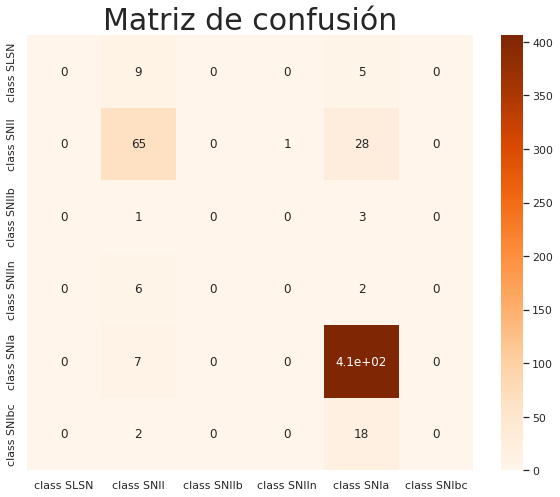

In [57]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

columns = ['class %s' %(i) for i in np.unique(y_true)]

confm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)
sn.set(rc={'figure.figsize':(10,8)})
ax.set_title('Matriz de confusión',fontsize=30)

In [60]:
# Accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print(accuracy_score(y_true, y_pred),'\n',
recall_score(y_true, y_pred, average=None),'\n',
precision_score(y_true, y_pred, average=None))


0.8517179023508138 
 [0.         0.69148936 0.         0.         0.98305085 0.        ] 
 [0.         0.72222222 0.         0.         0.87878788 0.        ]
